# 🤪 WGAN - CelebA 얼굴 데이터셋

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/04_gan/02_wgan_gp/wgan_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2023-05-23 07:33:31--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2023-05-23 07:33:32 (29.4 MB/s) - ‘utils.py’ saved [771/771]



이 노트북에서는 CelebA 얼굴 데이터 세트에서 와서스테인 GAN을 훈련합니다.

이 코드는 케라스 웹 사이트에 있는 훌륭한 [WGAN-GP 튜토리얼](https://keras.io/examples/generative/wgan_gp/)을 참고했습니다.

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

from notebooks.utils import display, sample_batch

## 0. 파라미터 <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 512
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

## 1. 데이터 준비 <a name="prepare"></a>

In [4]:
# 코랩일 경우 노트북에서 celeba 데이터셋을 받습니다.
if 'google.colab' in sys.modules:
    # 캐글-->Setttings-->API-->Create New Token에서 
    # kaggle.json 파일을 만들어 코랩에 업로드하세요.
    from google.colab import files
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    # celeba 데이터셋을 다운로드하고 압축을 해제합니다.
    !kaggle datasets download -d jessicali9530/celeba-dataset
    !unzip -q celeba-dataset.zip
    # output 디렉토리를 만듭니다.
    !mkdir output

Saving kaggle.json to kaggle.json
100% 1.33G/1.33G [01:04<00:00, 24.2MB/s]
100% 1.33G/1.33G [01:04<00:00, 22.2MB/s]


In [5]:
# 데이터 로드
train_data = utils.image_dataset_from_directory(
    "./img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [6]:
# 데이터 전처리
def preprocess(img):
    """
    이미지 정규화
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [7]:
# 훈련 세트에 있는 몇 개의 샘플 출력
train_sample = sample_batch(train)

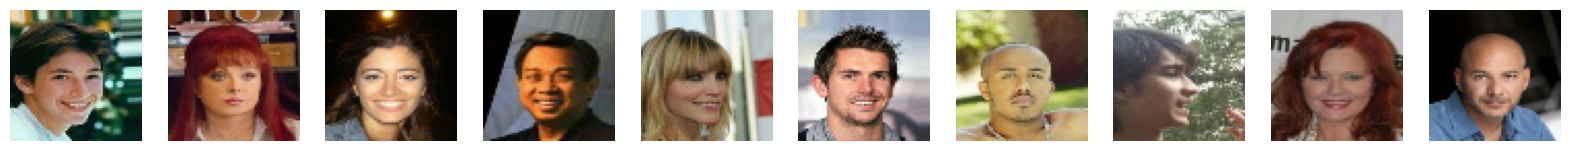

In [8]:
display(train_sample, cmap=None)

## 2. WGAN-GP 구축 <a name="build"></a>

In [9]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544

In [10]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        1048576   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [11]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [12]:
# GAN 만들기
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [13]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/checkpoint.ckpt")

## 3. GAN 훈련 <a name="train"></a>

In [14]:
# GAN 컴파일
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [15]:
# 모델 저장 체크포인트 만들기
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
            cmap=None,
        )

In [ ]:
# 깃허브 노트북 용량 제한 때문에 출력을 지웁니다.
wgangp.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=2,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [17]:
# 최종 모델 저장
generator.save("./models/generator")
critic.save("./models/critic")

## 이미지 생성

1/1 [==============================] - 0s 248ms/step


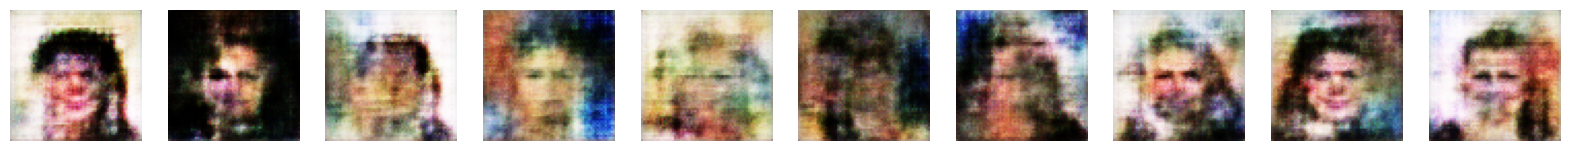

In [18]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)